In [2]:
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
from reader import Reader
import yaml
from const import Const
import random
import numpy as np
from utils import get_F_example
from clustering import Clusters
from sklearn.datasets.samples_generator import make_blobs
from i_merge import IMerger

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.graph_objs as go
import plotly.express as px

import pandas as pd

C:\Users\nekro\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df = pd.read_csv('output.csv')
df = df.sort_values(by=['id'])
df.head()

id         X1         X2         F  cluster_id  subcluster_id
11   1  25.388056  10.849605  3.202699           0              0
14   2  26.102651  11.895918  3.665356           0              0
13   3  24.843052  12.847889  4.452695           0              0
15   4  25.282225  12.889494  4.779293           0              0
9    5  26.000284  13.887626  5.216364           0              0

In [4]:
fig = px.scatter_3d(df, x='X1', y='X2', z='F',
              color='cluster_id')
fig.show()

In [5]:
consts = Const()
consts.calculate_a(df, type_of_optimization=2)
consts.config

C:\Users\nekro\Documents\Cluster\i\clusters\const.py:12: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



{'conturs': {'min_points': 30,
  'contour_points': 50,
  'min_diff': 1.68,
  'num_of_lenghts': 4},
 'isolated_cluster': {'constU1': 0.05,
  'min_len': 0.49,
  'min_dif': 1.68,
  'divider': 2,
  'max_div_num': 8,
  'merge_threshold': 1.75},
 'knots': {'min_fuses_num': 15, 'stop_const': 0.49},
 'consts': {'percent_for_norms': 40,
  'round_const': 2,
  'const': 0.25,
  'percent_X': 5,
  'down_steps': 0,
  'up_steps': 28,
  'power_koef': 1.16,
  'percent_Y': 33,
  'threshold': 0.8,
  'Y_step': 2.5,
  'a': 0.49}}

In [6]:
Merger = IMerger(consts.config)

In [7]:
Merger.mergeClusters(df)

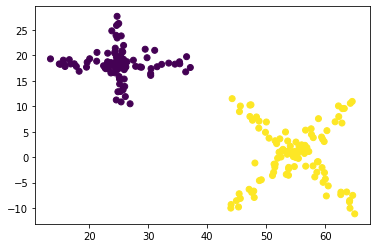

In [8]:
plt.scatter(df['X1'],df['X2'], c=df['cluster_id'])

In [9]:
fig = px.scatter_3d(df, x='X1', y='X2', z='F',
              color='cluster_id')
fig.show()

# My code

In [1]:
if 'Subcluster_id' in df.columns:
    del df['Subcluster_id']
num_clusters = len(set(df['Cluster_id']))
print(num_clusters)
df.head()

NameError: name 'df' is not defined

In [ ]:
plt.scatter(df['X1'],df['X2'], c=df['Cluster_id'])

In [ ]:
matrix = df.iloc[:, 1:-2].values
dist_matrix = np.zeros((len(matrix), len(matrix)))
for i in range(len(matrix)):
    for j in range(len(matrix)):
        dist_matrix[i,j] = distance.euclidean(matrix[i], matrix[j])
dist_matrix.shape

In [ ]:
id_cluster_matrix = df[['Id', 'Cluster_id']].iloc[:, ].values

In [ ]:
dist_arr = []
for line1 in id_cluster_matrix:
    a_dist = []
    # набираем расстояния
    for line2 in id_cluster_matrix:
        # если тот же кластер - лесом
        
        if line1[1] == line2[1]:
            continue
        a_dist.append(
            [line1[0], dist_matrix[int(line1[0])-1, int(line2[0])-1], line2[0], line2[1]])
    a_dist.sort(key=lambda i: float(i[1]), reverse=False)
    dist_arr.append(a_dist[0])

In [ ]:
good_dots = []

for b in dist_arr:
    for c in dist_arr:
        if b[0] == c[2] and b[1] == c[1]:
            good_dots.append(b)
len(good_dots)

In [ ]:
good_dots

In [ ]:
data = []
for g in good_dots:
    dot1 = df[df['Id']==g[0]]
    dot2 = df[df['Id']==g[2]]
    f_max_clus_1 = df[df['Cluster_id']==dot1['Cluster_id'].values[0]]['F'].max()
    f_max_clus_2 = df[df['Cluster_id']==dot2['Cluster_id'].values[0]]['F'].max()
    data.append({'p1':dot1.values[0,:], 'F_max_cluster1':f_max_clus_1, 'p2':dot2.values[0,:], 'F_max_cluster2':f_max_clus_2})
print(len(data))

In [ ]:
i = 0
while i<len(data):
    for j in range(len(data)):
        if data[i]['p1'][0]== data[j]['p2'][0] and j!=i:
            data.pop(j)
            break
    i += 1
print(len(data))
data

In [ ]:
def get_profile(F, p1, p2, min_len=1.52, min_dif=0.52, divider=2, max_div_num=8, min_diff=0.52, a=1.52):

    if np.linalg.norm(np.array(p1[1:-1]) - np.array(p2[1:-1]))/divider <= min_diff:
        return min(p1[-1],p2[-1])
    else:
        div_num = 0
        segment_len = np.linalg.norm( np.array(p1[1:-1]) - np.array(p2[1:-1]))
        while (div_num < max_div_num-1) and (segment_len > min_len):
            div_num+= 1
            num_of_segments = (divider+1)*div_num + divider
            segment_len = np.linalg.norm(np.array(p1[1:-1]) - np.array(p2[1:-1]))/num_of_segments

        if div_num == 0:
            return min(p1[-1],p2[-1])

        points = []
        for i in range(num_of_segments):
            x = [-1.]
            for j in range(1, len(p1)-1):
                x.append((p1[j] + p2[j]*(i+1)/(num_of_segments-i))/(1+(i+1)/(num_of_segments-i)))
            points.append(np.array(x))
#         plt.scatter([p1[1],p2[1]],[p1[2],p2[2]])
#         plt.annotate(str(p1[-1]), xy=(p1[1], p1[2]))
#         plt.annotate(str(p2[-1]), xy=(p2[1], p2[2]))
#         plt.scatter(np.array(points)[:,1],np.array(points)[:,2])
        Fs = [[point[1],  point[2], get_F_example([f[:-1] for f in F], a, target=point)] for point in points]
        min_F = Fs[0][-1]
        for s in Fs:
            if s[-1]<min_F:
                min_F = s[-1]
#             plt.annotate(str(s[-1]), xy=(s[0], s[1]))
#         plt.show()
        return min_F

In [ ]:
F = df.iloc[:].values[:,:4]

In [ ]:
F_matrix = np.full((num_clusters,num_clusters), np.inf)
for i in range(len(data)):
    if data[i]['F_max_cluster1']<=data[i]['F_max_cluster2']:
        F_max = data[i]['F_max_cluster1']
        x = int(data[i]['p2'][-1])
        y = int(data[i]['p1'][-1])
    else:
        F_max = data[i]['F_max_cluster2']
        x = int(data[i]['p1'][-1])
        y = int(data[i]['p2'][-1])
    delta = F_max - get_profile(F, data[i]['p1'][:-1], data[i]['p2'][:-1])
    if F_matrix[x, y] == np.inf:
        F_matrix[x, y] = delta
    elif F_matrix[x, y] > delta:
        F_matrix[x, y] = delta

In [ ]:
F_matrix

In [ ]:
def merge(M, num_clusters, df):
    
    min_item = M.argmin()
    row = min_item//num_clusters
    col = min_item%num_clusters
    M[row,col]=np.inf
    df.loc[df['Cluster_id']==col, 'Cluster_id'] = row
    print(df[df['Cluster_id']==col]['Cluster_id'])
    for i in range(num_clusters):
        if M[row,i]>M[col,i]:
            M[row,i] = M[col,i]
        M[col,i] = np.inf

In [ ]:
threshold = 2

In [ ]:
while F_matrix.min()<threshold:
    merge(F_matrix, num_clusters, df)

In [ ]:
plt.scatter(df['X1'],df['X2'], c=df['Cluster_id'])

In [ ]:
min_item = F_matrix.argmin()
row = min_item//num_clusters
col = min_item%num_clusters
F_matrix[row,col]=np.inf
df[df['Cluster_id']==col]['Cluster_id']=row
for i in range(num_clusters):
    if F_matrix[row,i]>F_matrix[col,i]:
        F_matrix[row,i] = F_matrix[col,i]
    F_matrix[col,i] = np.inf

In [ ]:
F_matrix

In [ ]:
df[df['Cluster_id']==col]['Cluster_id']